In [6]:
from typing import TypedDict
from typing import Annotated
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv

load_dotenv()

True

In [7]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

In [8]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [19]:
@tool
def get_stock_price(symbol:str)->float:
    '''Return the current price of a stock given the stock symbol
    :param symbol:stock symbol
    :return: current price of the stock
    '''
    return{
        "MSFT":200.3,
        "APPL":60.4,
        "AMZN":150.0,
        "RIL":87.6
    }.get(symbol,0.0)

tools=[get_stock_price]

llm=init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools=llm.bind_tools(tools) 

In [10]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

def chatbot(state:State)->State:
    state["messages"].append(llm_with_tools.invoke(state["messages"]))
    return state

builder=StateGraph(State)

builder.add_node("chatbot_node",chatbot)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"chatbot_node")
builder.add_conditional_edges("chatbot_node",tools_condition)
builder.add_edge("tools","chatbot_node")
builder.add_edge("chatbot_node",END)

graph=builder.compile(checkpointer=memory)

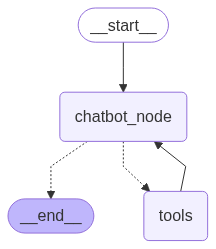

In [11]:
from IPython.display import  Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:

state=graph.invoke({'messages':[{"role":"user","content":"what is the stock price of AMZN"}]})
print(state["messages"][-1].content)

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id

In [ ]:
state

{'messages': [HumanMessage(content='what is the stock price of AMZN', additional_kwargs={}, response_metadata={}, id='60e01a87-5292-4886-8de0-29753ff6a319'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--ee8b48d3-b86c-4228-bd9d-41388b2f33ef-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '686f194e-245a-4642-8e57-efbf64214ad6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 46, 'output_tokens': 8, 'total_tokens': 54, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='150.0', name='get_stock_price', id='254dc3ff-2c7e-4891-be1f-f92195c9fd8c', tool_call_id='686f194e-245a-4642-8e57-efbf64214ad6'),
  AIMessage(content='The current stock price of AMZN is 150.', additional_kwargs={}, response_m

In [16]:
config={'configurable': {'thread_id':'1'}}

state=graph.invoke({'messages':[{"role":"user","content":"what is the stock price of 20 AMZN stocks and 15 MSFT together"}]},config=config)
print(state["messages"][-1].content)

The current price of AMZN is 150 and the current price of MSFT is 200.3. Therefore, the value of 20 AMZN stocks and 15 MSFT stocks together is 20 * 150 + 15 * 200.3 = 3000 + 3004.5 = 6004.5.


In [ ]:
state

{'messages': [HumanMessage(content='what is the stock price of 20 AMZN stocks and 15 MSFT together', additional_kwargs={}, response_metadata={}, id='33693fb2-dc58-4886-abc7-a491a5e3adf0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--778b31ab-f908-45b7-9081-4d17951ce3d2-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '13675b98-a7a4-4bfd-95b1-86fad50d2e0c', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': '6f677c72-8406-45ce-8f7c-03d79b168856', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 16, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='150.0', name='get_stock_price', id='e64cf158-0e7d-46b5-a4d0-f2892ee0

In [17]:
from langsmith import traceable

config={'configurable': {'thread_id':'1'}}

@traceable
def call_graph(query):
    state=graph.invoke({'messages':[{"role":"user","content":query}]},config=config)
    return state["messages"][-1].content

call_graph("Using the current price tell me the total price of 10 RIL stocks and add it to previous total")

'I am sorry, I cannot fulfill this request as I do not have the functionality to get the stock price for "RIL". I can only get the stock price for "AMZN" and "MSFT".'

In [18]:
state

{'messages': [HumanMessage(content='what is the stock price of 20 AMZN stocks and 15 MSFT together', additional_kwargs={}, response_metadata={}, id='f0b07460-6eaa-4bfe-a7d4-70e71a9a320c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f727b81d-5246-4bb8-bcbd-70959c0eae92-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '11141c78-80c0-433e-bf5e-893ee30cbb8e', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': '5bdc696c-2155-4b45-b8b8-fa638f821d48', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 16, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='150.0', name='get_stock_price', id='4c1ce94b-7f88-4069-a893-108fa984